In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz


--2023-05-18 12:41:26--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  99.9KB/s    in 44m 27s 

2023-05-18 13:25:53 (99.8 KB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=8e5c0b0f2c98c506e197089611447fd504b761e2a3770ee4bc50e24764ba41b0
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
!tar xf spark-3.2.1-bin-hadoop2.7.tgz


In [4]:
!pip install -q findspark

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [6]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("Read CSV Files") \
        .getOrCreate()


In [7]:
import os

# Set the directory path
dir_path = "/content/"

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(dir_path) if file.endswith('.csv')]

# Read each CSV file into a DataFrame and store it in a dictionary with the file name as the key
dfs = {}
for file in csv_files:
    file_path = os.path.join(dir_path, file)
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    dfs[file[:-4]] = df  # Use file name (without .csv extension) as key

# Print the first 20 rows of each DataFrame
for name, df in dfs.items():
    print(f"DataFrame '{name}':")
    df.show(10)

dfs['buy-clicks'] = dfs['buy-clicks'].withColumnRenamed("team", "teamId")

DataFrame 'users':
+-------------------+------+-----------+----------+----------+-------+
|          timestamp|userId|       nick|   twitter|       dob|country|
+-------------------+------+-----------+----------+----------+-------+
|2012-06-19 14:53:41|   442|   pcjIOBKW|  @SZhyOHv|1994-07-20|     BA|
|2012-06-19 19:29:01|   949|    vAOfUkf|    @nkkNo|1971-04-22|     HU|
|2012-06-20 19:34:59|  1654|     qOOXSQ|    @SwOlw|1970-04-19|     IS|
|2012-06-21 01:18:29|  1586|    px4gW51|  @IrCHTnE|1965-11-23|     AM|
|2012-06-21 15:35:00|   599|9gkfwRC73Uc|   @VJj0Az|1994-08-23|     CC|
|2012-06-22 11:36:19|   952| BRbb3VOTti|   @b4OK6K|1986-09-11|     MH|
|2012-06-23 08:11:18|  1056|    fGCIAtI| @IgDsdWdU|1991-11-28|     SM|
|2012-06-23 10:54:19|    91|tpDfgi3S0N9|   @LvTHGO|1977-07-03|     BZ|
|2012-06-23 14:59:26|   809| LkNRpRW6Ez|@ROrRkXwdh|1951-09-25|     PF|
|2012-06-23 17:40:35|    75|     fNWewX|   @OXqLyv|1979-11-12|     JO|
+-------------------+------+-----------+----------+-------

In [8]:
###schema and descriptions of all the dataframes

for key, item in dfs.items():
  print(f"Schema and Description of {key}")
  item.printSchema()
  item.describe().show()

Schema and Description of users
root
 |-- timestamp: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- nick: string (nullable = true)
 |-- twitter: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- country: string (nullable = true)

+-------+-------------------+-----------------+----------+--------+----------+-------+
|summary|          timestamp|           userId|      nick| twitter|       dob|country|
+-------+-------------------+-----------------+----------+--------+----------+-------+
|  count|               2393|             2393|      2393|    2393|      2393|   2393|
|   mean|               null|           1196.0|      null|    null|      null|   null|
| stddev|               null|690.9439195766904|      null|    null|      null|   null|
|    min|2012-06-19 14:53:41|                0|01hRCMOSWz|@00s8sd4|1946-07-23|     AD|
|    max|2016-06-16 05:39:34|             2392|  zundHJEB|  @zxVDB|1998-06-13|     ZW|
+-------+-------------------+--------

In [9]:
from pyspark.sql.functions import year, month, dayofmonth, to_date, datediff, current_date, when, col,count,when
from pyspark.sql.functions import col,isnan, when, count

#null values in all the dataframes

for key,item in dfs.items():
    print(f"Missing values in {key} dataset:")
    item.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in item.columns]).show()



# Explore the distribution of users by country
users_df = dfs["users"]
users_df.groupBy("country").count().show()

# Investigate the age distribution by calculating the age from the "dob" column and the "timestamp" column
users_df = users_df.withColumn("dob", to_date("dob", "MM/dd/yyyy"))
users_df = users_df.withColumn("age", datediff(current_date(), "dob")/365)
users_df.select("age").describe().show()

# Examine the distribution of users over time by analyzing the "timestamp" column
users_df = users_df.withColumn("year", year("timestamp"))
users_df = users_df.withColumn("month", month("timestamp"))
users_df = users_df.withColumn("day", dayofmonth("timestamp"))
users_df.groupBy("year", "month", "day").count().orderBy("year", "month", "day").show()


Missing values in users dataset:
+---------+------+----+-------+---+-------+
|timestamp|userId|nick|twitter|dob|country|
+---------+------+----+-------+---+-------+
|        0|     0|   0|      0|  0|      0|
+---------+------+----+-------+---+-------+

Missing values in chat_respond_team_chat dataset:
+-------+-------+----+
|chatid1|chatid2|date|
+-------+-------+----+
|      0|      0|   0|
+-------+-------+----+

Missing values in level-events dataset:
+---------+-------+------+---------+---------+
|timestamp|eventId|teamId|teamLevel|eventType|
+---------+-------+------+---------+---------+
|        0|      0|     0|        0|        0|
+---------+-------+------+---------+---------+

Missing values in chat_mention_team_chat dataset:
+---------+-------+----+
|chat_item|user_id|date|
+---------+-------+----+
|        0|      0|   0|
+---------+-------+----+

Missing values in chat_join_team_chat dataset:
+-------+-------------------+----+
|user_id|teamchat_session_id|date|
+-------+--

In [10]:
#Find the number of users who played the game on each platform type:
# Load the data into a Spark dataframe
import plotly.graph_objs as go
from plotly.offline import iplot

user_session_df = spark.read.format("csv").option("header", "true").load("/content/user-session.csv")

# Group by platform type and count the sessions
platform_counts = user_session_df.groupBy("platformType").count().toPandas()

# Define colors for the pie chart
colors = ['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845']

# Create the pie chart
data = [go.Pie(labels=platform_counts["platformType"], values=platform_counts["count"], 
               hole=0.3, marker=dict(colors=colors, line=dict(color='#FFFFFF', width=1)))]

# Set the layout
layout = go.Layout(title="Count of sessions by platform type")

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Display the chart
fig.show()



In [11]:
#Find the number of clicks on flamingos made by each team:
game_clicks_df = spark.read.format("csv").option("header", "true").load("/content/game-clicks.csv")
team_df = spark.read.format("csv").option("header", "true").load("/content/team.csv")
from pyspark.sql.functions import sum
flamingos_clicks_df = game_clicks_df.join(team_df, "teamId")
clicks_per_team = flamingos_clicks_df.groupBy("teamId").agg(sum("isHit").alias("clicks"))
clicks_per_team.show(5)

+------+------+
|teamId|clicks|
+------+------+
|    51|1000.0|
|    54|1000.0|
|    11|1000.0|
|    69|1000.0|
|    64|1000.0|
+------+------+
only showing top 5 rows



In [12]:
#Find the average price of items purchased by each team:
buy_clicks_df = spark.read.format("csv").option("header", "true").load("/content/buy-clicks.csv")
team_df = spark.read.format("csv").option("header", "true").load("/content/team.csv")
buy_clicks_df = buy_clicks_df.withColumnRenamed("team", "teamId")
buy_clicks_df = buy_clicks_df.withColumn("price", col("price").cast("float"))
purchase_per_team = buy_clicks_df.join(team_df, "teamId").groupBy("name").avg("price").orderBy('avg(price)', ascending=False)
purchase_per_team.show()


import plotly.express as px

# create a Plotly bar chart
fig = px.bar(purchase_per_team.limit(10).toPandas(), x='name', y='avg(price)', color='avg(price)', 
             color_continuous_scale=px.colors.sequential.Viridis, 
             labels={'name': 'Team Name', 'avg(price)': 'Average Price'})
fig.update_layout(title='Average Price of Items Purchased by Top 10 Team')
fig.show()

+-----------+------------------+
|       name|        avg(price)|
+-----------+------------------+
|  5aw5S13OD|           11.9375|
| qMqosm6tja|           11.1875|
|     zu8iuz|10.933333333333334|
|  0sicoF7Pl|10.777777777777779|
|I7dtH5Ixx5o|10.557377049180328|
| spSWFkoNDC|10.470588235294118|
|mjKIyWQpvVy|10.465116279069768|
|  bjymBRFFL|              10.0|
|R5SYibpiHpE|          9.171875|
|   XGDcC22k| 8.952380952380953|
|ALld75HTBh1| 8.730337078651685|
|    87oPQXq| 8.712871287128714|
|  w6rLDXAJO| 8.189873417721518|
|   cz8t6Wli| 8.145454545454545|
|     5izIUy| 8.090909090909092|
|  EkwgEvX3h| 7.872093023255814|
|    0TgEQap| 7.822222222222222|
|     5WSGJw| 7.809523809523809|
|   8q0Umalp| 7.708333333333333|
| F6QSBN0Q3T| 7.633333333333334|
+-----------+------------------+
only showing top 20 rows



In [13]:
from pyspark.sql.functions import col

# get unique values of a column
unique_values = dfs['game-clicks'].select(col("isHit")).distinct().collect()
print(unique_values)


[Row(isHit=1), Row(isHit=0)]


In [14]:
from pyspark.sql.functions import col

# join users, buy-clicks, and combined-data with game-clicks based on userId
mydata = dfs['users'].join(dfs['combined-data'], 'userId')
mydata = mydata.join(dfs['buy-clicks'].select(['txID','UserId','price']),'userId')
mydata.show()

+------+-------------------+-----------+----------+----------+-------+-------------+---------+------------+----------------+----------+-----------+---------+-----+-----+
|userId|          timestamp|       nick|   twitter|       dob|country|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price| txID|price|
+------+-------------------+-----------+----------+----------+-------+-------------+---------+------------+----------------+----------+-----------+---------+-----+-----+
|  1658|2014-05-25 20:36:33| VBAoAoPXtp|    @74pik|1977-03-29|     VE|         5649|        1|      iphone|              31|         5|       NULL|     NULL|30176| 10.0|
|  1658|2014-05-25 20:36:33| VBAoAoPXtp|    @74pik|1977-03-29|     VE|         5649|        1|      iphone|              31|         5|       NULL|     NULL|25986|  5.0|
|  1658|2014-05-25 20:36:33| VBAoAoPXtp|    @74pik|1977-03-29|     VE|         5649|        1|      iphone|              31|         5|       NULL|   

Average number of actions performed by each user: 16.24207858048162


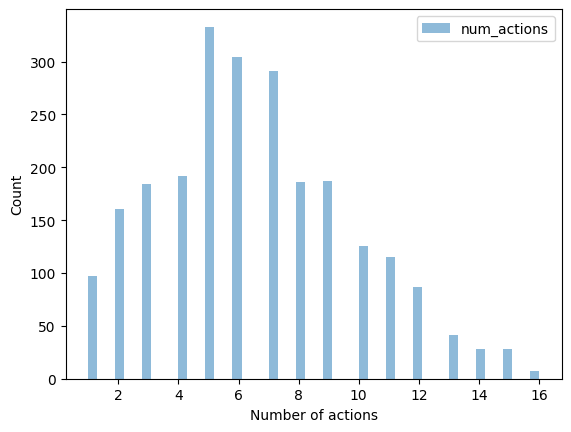

Total number of unique users: 2367
+----------+---------+------------------+
|count_hits|num_users|     percent_users|
+----------+---------+------------------+
|         0|       19|0.8027038445289396|
|         1|       44|1.8588931136459652|
|         2|       62| 2.619349387410224|
|         3|       62| 2.619349387410224|
|         4|       71| 2.999577524292353|
|         5|      110| 4.647232784114914|
|         6|      119| 5.027460920997043|
|         7|      123| 5.196451204055767|
|         8|      123| 5.196451204055767|
|         9|      133|5.6189269117025775|
|        10|      112| 4.731727925644275|
|        11|      126| 5.323193916349809|
|        12|      132| 5.576679340937896|
|        13|       96| 4.055766793409378|
|        14|      105| 4.435994930291509|
|        15|       94|3.9712716518800173|
|        16|       83| 3.506548373468526|
|        17|       58|   2.4503591043515|
|        18|       60|2.5348542458808616|
|        19|       52|2.1968736797634136|

In [15]:
##########  User engagement: ############
from pyspark.sql.functions import avg, countDistinct
import matplotlib.pyplot as plt
# Calculate the average number of actions performed by each user
avg_actions_per_user = mydata.groupBy("userSessionId").agg(avg("count_hits").alias("avg_count_hits")).agg(avg("avg_count_hits")).collect()[0][0]
print("Average number of actions performed by each user:", avg_actions_per_user)

# Plot a histogram of the number of actions performed by users
actions_per_user = mydata.groupBy("userSessionId").agg(countDistinct("txId").alias("num_actions")).select("num_actions").toPandas()
actions_per_user.plot.hist(bins=50, alpha=0.5)
plt.xlabel("Number of actions")
plt.ylabel("Count")
plt.show()

# Calculate the total number of unique users in the dataset
num_unique_users = mydata.select("userSessionId").distinct().count()
print("Total number of unique users:", num_unique_users)

# Calculate the percentage of users who performed a certain action
num_users_per_action = mydata.groupBy("count_hits").agg(countDistinct("userSessionId").alias("num_users")).sort("count_hits")
num_users_per_action = num_users_per_action.withColumn("percent_users", num_users_per_action.num_users/num_unique_users*100)
num_users_per_action.show()


In [16]:
########### demographic analysis ####################

import pandas as pd
import plotly.express as px

# Select the necessary columns
demographic_data = mydata.select('userId', 'dob', 'country', 'platformType')

# Convert the Spark DataFrame to a Pandas DataFrame
demographic_data = demographic_data.toPandas()

# Calculate the age of each user
demographic_data['age'] = pd.Timestamp.now().year - pd.to_datetime(demographic_data['dob'], format='%Y-%m-%d').dt.year


# Create a histogram of the age distribution
histogram = go.Histogram(x=demographic_data['age'], nbinsx=20)

# Set the layout for the plot
layout = go.Layout(title='Age Distribution', xaxis=dict(title='Age'), yaxis=dict(title='Count'))

# Create the plot and display it
fig = go.Figure(data=[histogram], layout=layout)
fig.show()

# Group users by country and platform
country_platform_counts = demographic_data.groupby(['country', 'platformType']).size().reset_index(name='count')

# Create a bar plot showing the distribution of users by location
fig = px.bar(demographic_data.groupby('country').size().reset_index(name='count'), x='country', y='count')
fig.update_layout(title='Distribution of Users by Location', xaxis_title='Country', yaxis_title='Number of Users')
fig.show()
#create a bar chart showing the distribution of users by platform
fig = px.bar(country_platform_counts, x='platformType', y='count', color='country', barmode='group')
fig.show()



<ipython-input-17-0060adce5e1e>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

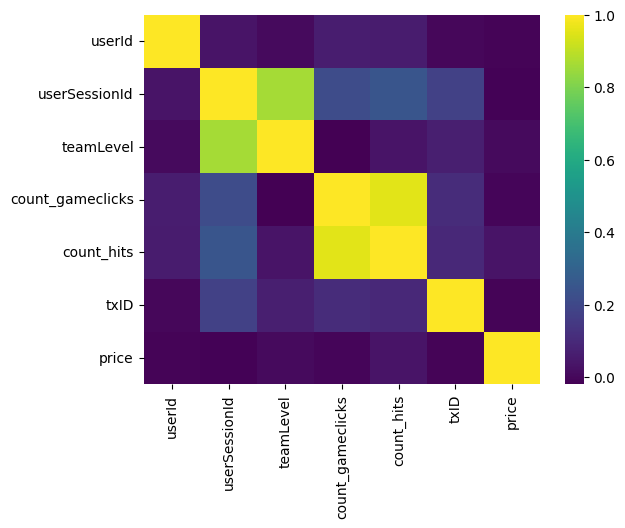

In [17]:
#heatmap for user behaviour data 
import seaborn as sns
sns.heatmap(mydata.toPandas().corr(), cmap="viridis")

In [18]:
ad_data = dfs['users'].drop('timestamp').join(dfs['ad-clicks'],'userId')
#Ad Category-wise User Distribution (Pie Chart):
import plotly.express as px
import pandas as pd

# Count the number of users for each ad category
category_count = ad_data.groupBy("adCategory").count().toPandas()

# Plot the pie chart
fig = px.pie(category_count, values='count', names='adCategory', 
             title='Ad Category-wise User Distribution', 
             labels={'count':'Number of Users', 'adCategory':'Ad Category'})

fig.show()



#############User Activity over Time (Line Chart):

from pyspark.sql.functions import hour, dayofweek

# Create a new column with the hour of the day
ad_data = ad_data.withColumn("hour", hour(ad_data.timestamp))

# Create a new column with the day of the week
ad_data = ad_data.withColumn("day_of_week", dayofweek(ad_data.timestamp))

# Group the data by hour and count the number of events
hourly_count = ad_data.groupBy("hour").count().orderBy("hour").collect()

# Convert the count to a dictionary for plotting
hourly_dict = {row["hour"]: row["count"] for row in hourly_count}

# Create the plot
fig = px.line(x=list(hourly_dict.keys()), y=list(hourly_dict.values()))
fig.update_layout(
    xaxis_title="Hour of the day",
    yaxis_title="Number of events",
    title="User Activity over Time"
)
fig.show()


In [19]:
#clustering
from itertools import cycle, islice
from math import sqrt
from numpy import array
from pandas.plotting import parallel_coordinates
from pyspark.ml.clustering import KMeans as KM
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)


def elbow(elbowset, clusters):
	wsseList = []	
	for k in clusters:
		print("Training for cluster size {} ".format(k))
		kmeans = KM(k = k, seed = 1)
		model = kmeans.fit(elbowset)
		transformed = model.transform(elbowset)
		featuresAndPrediction = transformed.select("features", "prediction")

		W = computeCost(featuresAndPrediction, model)
		print("......................WSSE = {} ".format(W))

		wsseList.append(W)
	return wsseList

def elbow_plot(wsseList, clusters):
	wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
	wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

def parallel_plot(data, P):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(P)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
 


#Clustering
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
featuresUsed = cols = ["count_gameclicks", "count_hits",'userId','teamLevel']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(mydata)


scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)


scaledData = scaledData.withColumn('label', scaledData['price'])


elbowset = scaledData.filter((scaledData.label % 3) == 0).select("features")
elbowset.persist()

clusters = range(2,31)

wsseList = elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 5714.784826921538 
Training for cluster size 3 
......................WSSE = 4828.165007552604 
Training for cluster size 4 
......................WSSE = 4140.272613130962 
Training for cluster size 5 
......................WSSE = 3737.5598383252227 
Training for cluster size 6 
......................WSSE = 3533.278318876929 
Training for cluster size 7 
......................WSSE = 3439.8113481181313 
Training for cluster size 8 
......................WSSE = 3164.0165148617443 
Training for cluster size 9 
......................WSSE = 3265.6165695669 
Training for cluster size 10 
......................WSSE = 2972.3396495088373 
Training for cluster size 11 
......................WSSE = 2874.9967722350893 
Training for cluster size 12 
......................WSSE = 2774.8270399308344 
Training for cluster size 13 
......................WSSE = 2740.117546859882 
Training for cluster size 14 
......................WSSE = 2646.4631

In [20]:
mydata

DataFrame[userId: int, timestamp: string, nick: string, twitter: string, dob: string, country: string, userSessionId: int, teamLevel: int, platformType: string, count_gameclicks: int, count_hits: int, count_buyId: string, avg_price: string, txID: int, price: double]

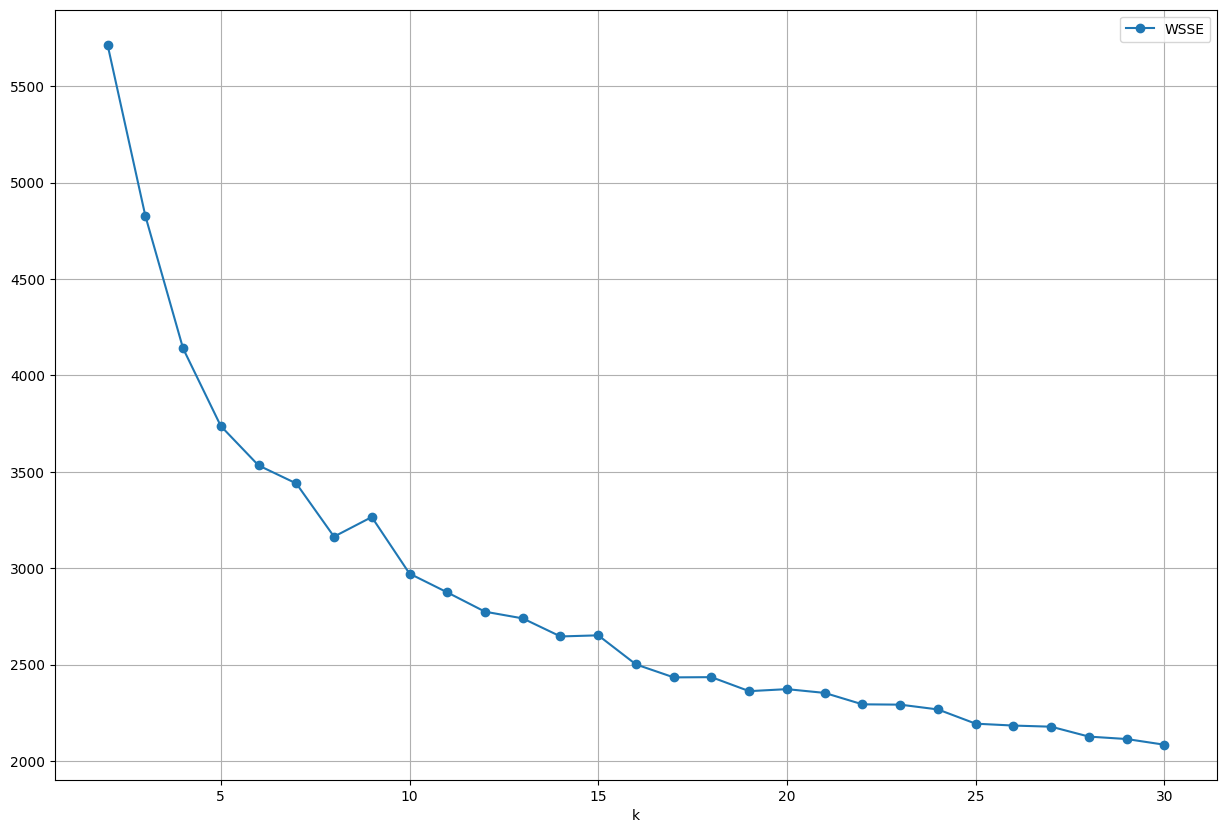

In [21]:
elbow_plot(wsseList, clusters)

In [22]:
########Classification ###################
classi_df = dfs['game-clicks']
classi_df.columns

['timestamp',
 'clickId',
 'userId',
 'userSessionId',
 'isHit',
 'teamId',
 'teamLevel']

In [23]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier,NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the label encoder
labelIndexer = StringIndexer(inputCol="teamLevel", outputCol="label").fit(classi_df)

# Apply the label encoder to the DataFrame
df = labelIndexer.transform(classi_df)

# Define the feature vector assembler
featureCols = ['clickId','userId','userSessionId','isHit','teamId']
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

# Apply the feature vector assembler to the DataFrame
df = assembler.transform(df)

# Split the DataFrame into training and testing sets
(trainingData, testData) = df.randomSplit([0.9, 0.1])

# Define the Random Forest Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Train the Random Forest Classifier on the training data
model = rf.fit(trainingData)

# Make predictions on the testing data
predictions = model.transform(testData)

# Evaluate the accuracy of the predictions
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy of the model
print(f"Accuracy  = {round(accuracy*100,2)}%")




Accuracy  = 80.74%


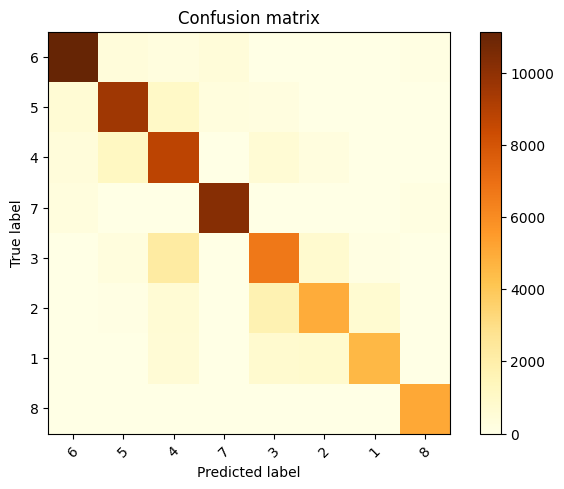

In [24]:
#################Plotting confusion matrix for above classification #######################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pyspark.sql.functions import col

# Convert the predictions DataFrame to a pandas DataFrame
y_true = np.array(predictions.select(col("label")).collect())
y_pred = np.array(predictions.select(col("prediction")).collect())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = labelIndexer.labels


# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.YlOrBr)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()


In [26]:
##### For Graph Analysis #############################
!pip install neo4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
!wget -O - https://debian.neo4j.com/neotechnology.gpg.key | sudo apt-key add -
!echo 'deb https://debian.neo4j.com stable latest' | sudo tee -a /etc/apt/sources.list.d/neo4j.list
!sudo apt-get update
!sudo apt-get install neo4j

--2023-05-18 13:39:19--  https://debian.neo4j.com/neotechnology.gpg.key
Resolving debian.neo4j.com (debian.neo4j.com)... 65.8.49.36, 65.8.49.24, 65.8.49.89, ...
Connecting to debian.neo4j.com (debian.neo4j.com)|65.8.49.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6342 (6.2K) [application/pgp-keys]
Saving to: ‘STDOUT’

-                   100%[===================>]   6.19K  --.-KB/s    in 0s      

2023-05-18 13:39:19 (111 MB/s) - written to stdout [6342/6342]

OK
deb https://debian.neo4j.com stable latest
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://debian.neo4j.com stable InRelease [44.2 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://archi

In [28]:
!sudo neo4j start

Directories in use:
home:         /var/lib/neo4j
config:       /etc/neo4j
logs:         /var/log/neo4j
plugins:      /var/lib/neo4j/plugins
import:       /var/lib/neo4j/import
data:         /var/lib/neo4j/data
certificates: /var/lib/neo4j/certificates
licenses:     /var/lib/neo4j/licenses
run:          /var/lib/neo4j/run
Starting Neo4j.
Started neo4j (pid:20024). It is available at http://localhost:7474
There may be a short delay until the server is ready.


In [29]:
!pip install graphdatascience
#!pip install neo4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.0/919.0 kB 14.2 MB/s eta 0:00:00


In [30]:
########## to change the password #############

from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
username = "neo4j"
password = "neo4j"
new_password = "admin123"

# Connect to the system database using the expired password
driver = GraphDatabase.driver(uri, auth=(username, password), encrypted=False)

# Change the password of the 'neo4j' user
with driver.session(database="system") as session:
    session.run(f"ALTER CURRENT USER SET PASSWORD FROM '{password}' TO '{new_password}'")

# Disconnect from the database and reconnect using the new password
driver.close()
driver = GraphDatabase.driver(uri, auth=(username, new_password), encrypted=False)

# Test the new password
with driver.session() as session:
    result = session.run("MATCH (n) RETURN count(n) AS node_count")
    node_count = result.single()["node_count"]
    print("There are {} nodes in the database.".format(node_count))

# Close the driver
driver.close()



There are 0 nodes in the database.


In [31]:
chat = {}
for i in dfs.keys():
  if i[0:4]=="chat":
    print("Dataframe name is : ",i)
    chat[i]=dfs[i]
    dfs[i].printSchema()

Dataframe name is :  chat_respond_team_chat
root
 |-- chatid1: integer (nullable = true)
 |-- chatid2: integer (nullable = true)
 |-- date: integer (nullable = true)

Dataframe name is :  chat_mention_team_chat
root
 |-- chat_item: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- date: integer (nullable = true)

Dataframe name is :  chat_join_team_chat
root
 |-- user_id: integer (nullable = true)
 |-- teamchat_session_id: integer (nullable = true)
 |-- date: integer (nullable = true)

Dataframe name is :  chat_leave_team_chat
root
 |-- user_id: integer (nullable = true)
 |-- teamchat_session_id: integer (nullable = true)
 |-- date: integer (nullable = true)



In [32]:
from neo4j import GraphDatabase

# Set up the connection to the Neo4j instance
uri = "bolt://localhost:7687"
user = "neo4j"
password = "admin123"
driver = GraphDatabase.driver(uri, auth=(user, password))

import pandas as pd
from neo4j import GraphDatabase

# Set up the connection to the Neo4j instance
uri = "bolt://localhost:7687"
user = "neo4j"
password = "admin123"
driver = GraphDatabase.driver(uri, auth=(user, password))

# Read the CSV file into a pandas dataframe
df = pd.read_csv("/content/chat_join_team_chat.csv")

with driver.session() as session:
    for index, row in df.iterrows():
        query = (
            "MERGE (a:User {id: $id_a})"
            "MERGE (b:Session {id: $id_b})"
            "MERGE (a)-[:PARTICIPATED_IN]->(b)"
        )
        params = {
            "id_a": row["user_id"],
            "id_b": row["teamchat_session_id"],
        }
        session.run(query, params)

# Import chat_respond_team_chat.csv
df = pd.read_csv("/content/chat_respond_team_chat.csv")

with driver.session() as session:
    for index, row in df.iterrows():
        query = (
            "MERGE (a:Chat {id: $id_a})"
            "MERGE (b:Chat {id: $id_b})"
            "MERGE (d:Date {date: $date})"
            "MERGE (a)-[:RESPOND]->(b)"
            "MERGE (a)-[:DATE]->(d)"
        )
        params = {
            "id_a": row["chatid1"],
            "id_b": row["chatid2"],
            "date": row["date"]
        }
        session.run(query, params)

# Import chat_leave_team_chat.csv
df = pd.read_csv("/content/chat_leave_team_chat.csv")

with driver.session() as session:
    for index, row in df.iterrows():
        query = (
            "MERGE (a:User {id: $id_a})"
            "MERGE (b:Session {id: $id_b})"
            "MERGE (d:Date {date: $date})"
            "MERGE (a)-[:LEFT]->(b)"
            "MERGE (a)-[:DATE]->(d)"
        )
        params = {
            "id_a": row["user_id"],
            "id_b": row["teamchat_session_id"],
            "date": row["date"]
        }
        session.run(query, params)

# Import chat_mention_team_chat.csv
df = pd.read_csv("/content/chat_mention_team_chat.csv")

with driver.session() as session:
    for index, row in df.iterrows():
        query = (
            "MERGE (a:ChatItem {id: $id_a})"
            "MERGE (b:User {id: $id_b})"
            "MERGE (d:Date {date: $date})"
            "MERGE (b)-[:MENTIONED]->(a)"
            "MERGE (a)-[:DATE]->(d)"
        )
        params = {
            "id_a": row["chat_item"],
            "id_b": row["user_id"],
            "date": row["date"]
        }
        session.run(query, params)


# Close the Neo4j driver instance
driver.close()



In [33]:
# Define Neo4j driver instance
driver = GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j", "admin123"))

# Define Cypher query to run Louvain algorithm
query = """
CALL gds.graph.create(
    'myGraph',
    ['User', 'Session'],
    {
        PARTICIPATED_IN: {
            orientation: 'UNDIRECTED',
            properties: 'date'
        }
    }
)

CALL gds.louvain.stream('myGraph')
YIELD nodeId, communityId
WITH gds.util.asNode(nodeId) AS user, communityId
MERGE (c:Community {id: communityId})
MERGE (user)-[:MEMBER_OF]->(c)
"""

# Run the query and print the results
with driver.session() as session:
    result = session.run(query)
    print(result.summary().counters)




ClientError: ignored

In [34]:
from yfiles_jupyter_graphs import GraphWidget
GraphWidget(graph=result)

ModuleNotFoundError: ignored

In [35]:
from google.colab import output
output.enable_custom_widget_manager()